In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 12 08:45:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 169 µs (started: 2022-02-12 08:45:15 +00:00)


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 9.55 ms (started: 2022-02-12 08:45:15 +00:00)


In [4]:
!pip install --quiet optuna

time: 3.52 s (started: 2022-02-12 08:45:15 +00:00)


In [5]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params


from xgboost import XGBClassifier

import optuna # hyeperparam optimization 

time: 4.28 s (started: 2022-02-12 08:45:19 +00:00)


# Variables

## Paths

In [6]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220212_08H45/
time: 6.35 ms (started: 2022-02-12 08:45:23 +00:00)


## Other

In [7]:
# seed
random_seed = 42

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# retrain or load previously trained
retrain_model=True
# previously trained model dir 
model_dir = export_dir if retrain_model else "/content/"
# PREVIOUSLY TRAINED MODEL CHOOSE 7 or 2 epochs unfreeze  
trained_model_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Hybrid DL+ML/Final DL model_2epochs unfreezed/'
trained_model_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Hybrid DL+ML/Final DL model_7epochs unfreezed/'
zip_trained_model_dir =  trained_model_dir + 'final_model.zip'

# epoch
epochs = 20
# epoch 2nd step:
n_epochs_2nd_step = 20 # 2 to stop just before overfit sur loss / 20 sinon pour laisser early stop faire le job 
# define base model  
model_name = 'EFB1'
base_model = tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False)
# feat extractor param 
# learing rate 
lr =9.972011089930672e-05 
# batch size 
batch_size = 16
# classifier architecture 
n_units_1, n_units_2 = 1024, 512
dropout_1, dropout_2 = 0.3 , 0.2 

# optuna & xgboostoptimiztion
tree_method = 'gpu_hist' if int(os.environ["COLAB_GPU"]) > 0 else 'hist'
n_trials = 50 # number optuna bayesian opt 
# XGBOSST inside objective 
n_estimators = 500 # nombre d'arbre xgboosting MAX qui sera limité par l'early stopping
early_stopping_rounds = 25  # window of the number of epochs over which no improvement is observed


# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 2.92 s (started: 2022-02-12 08:45:23 +00:00)


# Load & filter data

## Unzip images

In [8]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 2.91 ms (started: 2022-02-12 08:45:26 +00:00)


In [9]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 1.65 ms (started: 2022-02-12 08:45:26 +00:00)


## File_path df

In [10]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.75 s (started: 2022-02-12 08:45:26 +00:00)


In [11]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 2.93 ms (started: 2022-02-12 08:45:28 +00:00)


In [12]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 253 ms (started: 2022-02-12 08:45:28 +00:00)


In [13]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 156 ms (started: 2022-02-12 08:45:28 +00:00)


In [14]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 46.3 ms (started: 2022-02-12 08:45:28 +00:00)


In [15]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 40.3 ms (started: 2022-02-12 08:45:28 +00:00)


In [16]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 52.7 ms (started: 2022-02-12 08:45:28 +00:00)


In [17]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 37.5 ms (started: 2022-02-12 08:45:28 +00:00)


In [18]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 21.7 ms (started: 2022-02-12 08:45:28 +00:00)


In [19]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 56.9 ms (started: 2022-02-12 08:45:28 +00:00)


In [20]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.52 ms (started: 2022-02-12 08:45:28 +00:00)


In [21]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 26.3 ms (started: 2022-02-12 08:45:28 +00:00)


In [22]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.72 ms (started: 2022-02-12 08:45:28 +00:00)


In [23]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 17.8 ms (started: 2022-02-12 08:45:28 +00:00)


In [24]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 4.05 ms (started: 2022-02-12 08:45:28 +00:00)


## Train/test split

In [25]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(3200, 3) (800, 3) (1000, 3)
time: 26.1 ms (started: 2022-02-12 08:45:28 +00:00)


In [26]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 4.72 ms (started: 2022-02-12 08:45:28 +00:00)


### Plot few images

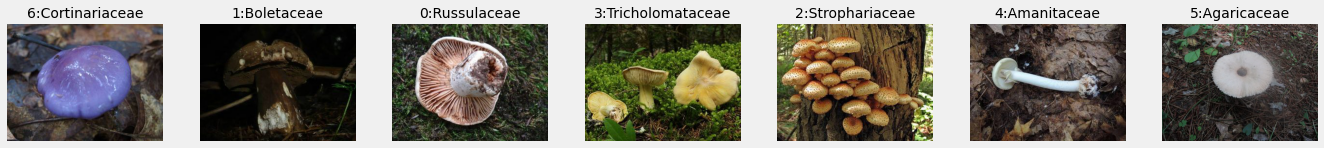

time: 394 ms (started: 2022-02-12 08:45:28 +00:00)


In [27]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

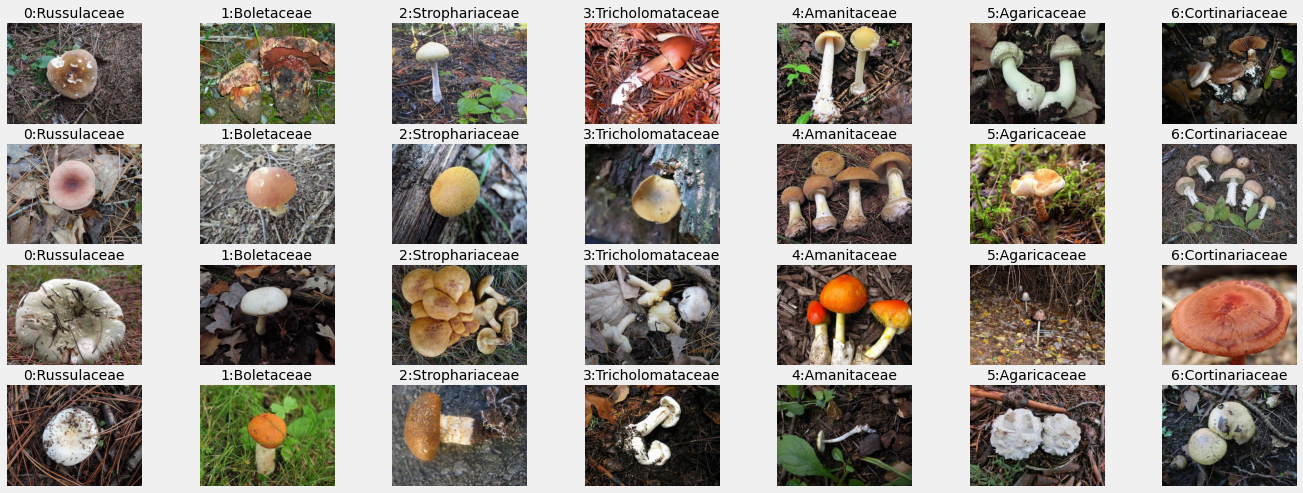

time: 1.65 s (started: 2022-02-12 08:45:29 +00:00)


In [28]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  try:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
    plt.imshow(im)
    label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
    plt.title(label,size = 14)
    plt.axis('off')
  except:
    continue
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Callbacks & Fonctions

In [29]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=2, # Attendre 2 epochs avant application
                                min_delta = 0.02, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping_step2 = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 6.41 ms (started: 2022-02-12 08:45:30 +00:00)


In [30]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 17.6 ms (started: 2022-02-12 08:45:30 +00:00)


In [31]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze=None):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))
  
  x = np.arange(1,(len(history['loss']))+1,1)
  plt.subplot(121)
  plt.plot(x, history['loss'], '-o', label = "training")
  plt.plot(x, history['val_loss'],  '-o',label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(x, history['accuracy'], '-o', label = "training")
  plt.plot(x, history['val_accuracy'], '-o', label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 39.6 ms (started: 2022-02-12 08:45:30 +00:00)


In [32]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 50.5 ms (started: 2022-02-12 08:45:31 +00:00)


In [33]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 61 ms (started: 2022-02-12 08:45:31 +00:00)


# Train feat extractor in two steps

In [35]:
# load model 
if not retrain_model:
  main_path = "/content/final_model"   
  if os.path.exists(main_path)== False :
    !unzip "$zip_trained_model_dir"  -d "/content"
  model = keras.models.load_model(model_dir +  'final_model')

time: 2.61 ms (started: 2022-02-12 08:47:26 +00:00)


## First step

In [36]:
if retrain_model:
  # Clear clutter from previous TensorFlow graphs.
  tf.keras.backend.clear_session()
  # datagen 
  # train 
  train_data_generator_  = ImageDataGenerator(
                                            # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                            ) 
  train_generator_ = train_data_generator_.flow_from_dataframe(dataframe = df_train_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  # val
  val_data_generator = ImageDataGenerator() 
  val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')



  # construct model 
  # base + average 
  layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()]
  # dense + dropout 
  layers.append(tf.keras.layers.Dense(units = n_units_1, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_1))
  layers.append(tf.keras.layers.Dense(units = n_units_2, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_2)) 
  # prediction 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = False
  #create model 
  model = tf.keras.Sequential(layers,name = model_name)
  model.summary()
  # export summary model & param 
  pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  with open(export_dir + '_modelsummary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))
  # compilation 
  optimizer =  'Adam'
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  print('lr={}'.format(K.eval(model.optimizer.lr)))
  # Entraînement
  tic = time.time() # timer start
  training_history_model_1 = model.fit(train_generator_,epochs=epochs,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                            early_stopping_step1,
                                            reduce_learning_rate, 
                                              ],
                                  )
else: 
  model.summary()

Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropou

## Second step

**************************************************setting base model trainable**************************************************
trainable_count = 8291271 / non_trainable_count =  124103
lr=9.972011321224272e-05 / batch_size = 16
Epoch 6/25
200/200 [==============================] - 71s 303ms/step - loss: 1.0308 - accuracy: 0.6206 - val_loss: 1.2254 - val_accuracy: 0.5788 - lr: 9.9720e-05
Epoch 7/25
200/200 [==============================] - 59s 295ms/step - loss: 0.6963 - accuracy: 0.7550 - val_loss: 1.0814 - val_accuracy: 0.6137 - lr: 9.9720e-05
Epoch 8/25
200/200 [==============================] - 59s 294ms/step - loss: 0.4404 - accuracy: 0.8456 - val_loss: 1.1396 - val_accuracy: 0.6388 - lr: 9.9720e-05
Epoch 9/25
200/200 [==============================] - 59s 294ms/step - loss: 0.2630 - accuracy: 0.9169 - val_loss: 1.2472 - val_accuracy: 0.6325 - lr: 9.9720e-05
Epoch 10/25
200/200 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9400
Epoch 00010: ReduceLROnPl

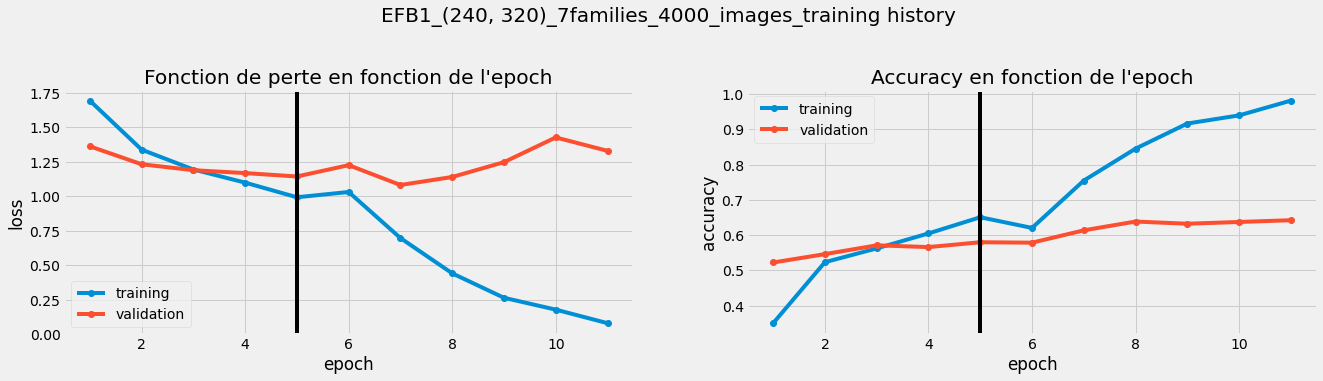

INFO:tensorflow:Assets written to: /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220212_08H45/final_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


time: 7min 5s (started: 2022-02-12 08:48:41 +00:00)


In [37]:
if retrain_model: 
  #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
  print("*"*50 + 'setting base model trainable' + '*'*50)
  efB1_layers = model.get_layer(index=0) # get all efB1 layers when we load a model 
  for layer in efB1_layers.layers:
        layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
  # check
  print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
  # compile 2nd setp 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  # get last lr 
  lr = training_history_model_1.history['lr'][-1] 
  K.set_value(model.optimizer.learning_rate, lr) 
  print('lr={} / batch_size = {}'.format(K.eval(model.optimizer.lr),batch_size))
  # define last epoch number to keep up
  max_epoch_freeze = len(training_history_model_1.history['accuracy'])
  # fine tuning 
  training_history_model_2 = model.fit(train_generator_,initial_epoch = max_epoch_freeze, # specify initial epoch 
                                  epochs=max_epoch_freeze + n_epochs_2nd_step,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                              early_stopping_step2,
                                              reduce_learning_rate
                                              ],
                                  )
  # timer end 
  tac = time.time()
  time_to_fit = tic - tac
  print('fite time = {}'.format(-round(time_to_fit/60,1)))
  # concat history 
  training_history_model = {}
  for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
    training_history_model[k1] = v1 +v2 
  # Plot hIStory 
  training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
  display(training_history_fig)
  # save fig
  training_history_fig.savefig(export_dir +   '_training_history.jpeg',bbox_inches = 'tight' )
  # save model 
  model.save(export_dir  +  'final_model')
else:
  plt.figure(figsize=(20,10))
  im = io.imread(trained_model_dir + '_training_history.jpeg')
  plt.axis('off')
  plt.imshow(im)

## Test set results using DL only

In [38]:
# predict 
print("*"*50 + 'Predicting labels' + '*'*50)
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
y_prob = model.predict(test_generator,len(df_test)//batch_size)
test_pred_class= np.argmax(y_prob , axis=1)

**************************************************Predicting labels**************************************************
Found 1000 validated image filenames belonging to 7 classes.
time: 4.59 s (started: 2022-02-12 08:55:47 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       171
           1       0.72      0.83      0.77       169
           2       0.60      0.69      0.64       126
           3       0.62      0.58      0.60       139
           4       0.82      0.72      0.77       133
           5       0.65      0.63      0.64       147
           6       0.52      0.50      0.51       115

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



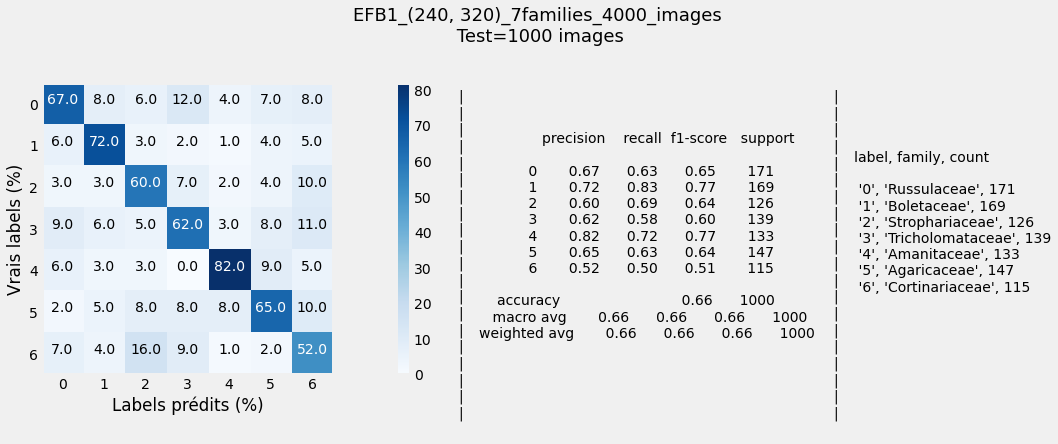

time: 805 ms (started: 2022-02-12 08:55:52 +00:00)


In [39]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'DL_model_conf_matrix.jpeg' ,bbox_inches = 'tight')

# Optuna + xgboost

In [40]:
# on regenere un train et un valids genrators sans shuffle 
train_generator_ = train_data_generator_.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                            shuffle = False,
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                        shuffle = False,
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')


Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
time: 46.1 ms (started: 2022-02-12 08:55:52 +00:00)


In [64]:
def objective(trial):
  print('*'*50 + 'Trial' + str(trial.number) + '/' + str(n_trials) + ' started' + '*'*50)
  # define features extracted 
  # layer 1 pour global average layer (voir comment faire pour couches EFB1 :https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/ )
  # layer_number = int(trial.suggest_discrete_uniform('layer_number', 1, len(model.layers)-2,1)) 
  layer_number = 2
  print('DL model layer output = {}'.format(model.layers[layer_number].name))
  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)
  X_train_features_  = intermediate_layer_model.predict(train_generator_ )
  X_val_features = intermediate_layer_model.predict(val_generator)
  print(X_train_features_.shape,X_val_features.shape)
  # define target 
  y_train_ ,  y_val = df_train_['label'] , df_val_['label']

  # trial param  
  # layer_number = int(trial.suggest_discrete_uniform('layer_unfreeze',0,339,1)) plus tard 
  params = {
      # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
      'tree_method':tree_method, 
        # metric 
      "objective": "multi:softmax",
      # "eval_metric": "mlogloss",
      "num_class":7,
      # other 
      # "verbosity": 0,  # 0 (silent) - 3 (debug)
      "n_estimators": n_estimators, #  NOMBRE D'ARBRE MAX sera ajusté par early stopping 
      "max_depth": trial.suggest_int("max_depth", 15, 25), # 2, 25
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
      "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.02, 0.2), # 0.2, 0.6
      "subsample": trial.suggest_loguniform("subsample", 0.1, 0.8), #0.4, 0.8
      "alpha": trial.suggest_loguniform("alpha", 1, 100.0), #  0.01, 10.0
      "lambda": trial.suggest_loguniform("lambda", 1, 100), #1e-8, 10.0
      "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0), #  1e-8, 10.0
      "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
      "seed": random_seed,
      "n_jobs": -1,
  }
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  # ML model 
  xgb_model= XGBClassifier(**params) # Add a callback for pruning cf optuna 
  
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-mlogloss") # pruning sur le set d'evaluation
  # ML model fit 
  xgb_model.fit(
                X_train_features_ , y_train_ ,
                eval_set=[(X_train_features_ ,y_train_ ),(X_val_features, y_val)],
                eval_metric="mlogloss",
                verbose=False,
                 callbacks=[pruning_callback],
                early_stopping_rounds=early_stopping_rounds, # DEF EARLY STOPPING 
                )
   # recupere le nombre de rounds pour future train avec le bon nombre via early stopping et pas celui donné par defaut
  n_estimators_early_stop = len(xgb_model.evals_result()['validation_1']['mlogloss']) # https://github.com/optuna/optuna/issues/1169 & https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
  trial.set_user_attr('n_estimators', n_estimators_early_stop) # <=> epoch 
  print('n_estimators_early_stop = {}'.format(n_estimators_early_stop))
  # get resutlts 
  results = xgb_model.evals_result()
  val_loss = results['validation_1']['mlogloss'][-1]
  # predict on train et validation set 
  train_score = xgb_model.score(X_train_features_ ,y_train_ )
  val_score = xgb_model.score(X_val_features,y_val)
  print('train/val acc={}/{}'.format(train_score,val_score))
  #add to df for later 
  trial.set_user_attr('train score',train_score) # accuracy on valid 
  trial.set_user_attr('valid score',val_score) # accuracy on valid 

  
  return val_loss # a voir si on prend pas l'accuracy plus tard 

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective,n_trials=n_trials,callbacks= [lambda study, trial: gc.collect()])

[I 2022-02-12 09:30:14,978] A new study created in memory with name: no-name-45cb69f3-53d0-4cdd-a77c-1a092894beb0


**************************************************Trial0/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 0:{'max_depth': 23, 'learning_rate': 0.007175523797023391, 'colsample_bytree': 0.1347310993467065, 'subsample': 0.12201188507890962, 'alpha': 6.217234306502348, 'lambda': 89.25046449873359, 'gamma': 2.2422994255661483e-08, 'min_child_weight': 12.490036325036526}
n_estimators_early_stop = 500


[I 2022-02-12 09:32:58,347] Trial 0 finished with value: 1.050612 and parameters: {'max_depth': 23, 'learning_rate': 0.007175523797023391, 'colsample_bytree': 0.1347310993467065, 'subsample': 0.12201188507890962, 'alpha': 6.217234306502348, 'lambda': 89.25046449873359, 'gamma': 2.2422994255661483e-08, 'min_child_weight': 12.490036325036526}. Best is trial 0 with value: 1.050612.


train/val acc=0.9934375/0.655
**************************************************Trial1/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 1:{'max_depth': 17, 'learning_rate': 0.014710668000800753, 'colsample_bytree': 0.06969648275573055, 'subsample': 0.26978554422214973, 'alpha': 15.708022303361934, 'lambda': 11.991057412602848, 'gamma': 4.808088443990492, 'min_child_weight': 1.559612713085435}
n_estimators_early_stop = 402


[I 2022-02-12 09:33:27,944] Trial 1 finished with value: 0.962785 and parameters: {'max_depth': 17, 'learning_rate': 0.014710668000800753, 'colsample_bytree': 0.06969648275573055, 'subsample': 0.26978554422214973, 'alpha': 15.708022303361934, 'lambda': 11.991057412602848, 'gamma': 4.808088443990492, 'min_child_weight': 1.559612713085435}. Best is trial 1 with value: 0.962785.


train/val acc=1.0/0.66
**************************************************Trial2/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 2:{'max_depth': 24, 'learning_rate': 0.023224278155931432, 'colsample_bytree': 0.07410549855244404, 'subsample': 0.1379598564235194, 'alpha': 16.964867952920102, 'lambda': 19.663616726715652, 'gamma': 2.5996233413832144e-07, 'min_child_weight': 19.071230592984442}
n_estimators_early_stop = 500


[I 2022-02-12 09:38:30,676] Trial 2 finished with value: 0.969107 and parameters: {'max_depth': 24, 'learning_rate': 0.023224278155931432, 'colsample_bytree': 0.07410549855244404, 'subsample': 0.1379598564235194, 'alpha': 16.964867952920102, 'lambda': 19.663616726715652, 'gamma': 2.5996233413832144e-07, 'min_child_weight': 19.071230592984442}. Best is trial 1 with value: 0.962785.


train/val acc=0.9975/0.6425
**************************************************Trial3/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 3:{'max_depth': 20, 'learning_rate': 0.04161453327989655, 'colsample_bytree': 0.0964733171974978, 'subsample': 0.29335507020775353, 'alpha': 21.955895433140206, 'lambda': 62.75890034057785, 'gamma': 0.005980052606552584, 'min_child_weight': 71.0612075870067}


[I 2022-02-12 09:39:05,608] Trial 3 finished with value: 0.990343 and parameters: {'max_depth': 20, 'learning_rate': 0.04161453327989655, 'colsample_bytree': 0.0964733171974978, 'subsample': 0.29335507020775353, 'alpha': 21.955895433140206, 'lambda': 62.75890034057785, 'gamma': 0.005980052606552584, 'min_child_weight': 71.0612075870067}. Best is trial 1 with value: 0.962785.


n_estimators_early_stop = 428
train/val acc=0.9921875/0.65625
**************************************************Trial4/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 4:{'max_depth': 18, 'learning_rate': 0.049249766538633985, 'colsample_bytree': 0.023624009275923254, 'subsample': 0.4128952395488022, 'alpha': 81.3262825531796, 'lambda': 19.389176240862298, 'gamma': 0.0008492138402242417, 'min_child_weight': 8.747682031714636}
n_estimators_early_stop = 174


[I 2022-02-12 09:39:24,710] Trial 4 finished with value: 0.953275 and parameters: {'max_depth': 18, 'learning_rate': 0.049249766538633985, 'colsample_bytree': 0.023624009275923254, 'subsample': 0.4128952395488022, 'alpha': 81.3262825531796, 'lambda': 19.389176240862298, 'gamma': 0.0008492138402242417, 'min_child_weight': 8.747682031714636}. Best is trial 4 with value: 0.953275.


train/val acc=1.0/0.65625
**************************************************Trial5/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 5:{'max_depth': 18, 'learning_rate': 0.02337782434010236, 'colsample_bytree': 0.10966254271295366, 'subsample': 0.3603016790577269, 'alpha': 1.6848334051728993, 'lambda': 1.0679867782802168, 'gamma': 0.005678015946336344, 'min_child_weight': 77.96346498928808}


[I 2022-02-12 09:39:37,171] Trial 5 pruned. Trial was pruned at iteration 1.


**************************************************Trial6/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 6:{'max_depth': 20, 'learning_rate': 0.005600787769639635, 'colsample_bytree': 0.020827312353550363, 'subsample': 0.12927478817267998, 'alpha': 15.194863484326858, 'lambda': 79.55284695657451, 'gamma': 0.003203448934244142, 'min_child_weight': 3.8593423555529855}
n_estimators_early_stop = 500


[I 2022-02-12 09:40:21,622] Trial 6 finished with value: 1.137556 and parameters: {'max_depth': 20, 'learning_rate': 0.005600787769639635, 'colsample_bytree': 0.020827312353550363, 'subsample': 0.12927478817267998, 'alpha': 15.194863484326858, 'lambda': 79.55284695657451, 'gamma': 0.003203448934244142, 'min_child_weight': 3.8593423555529855}. Best is trial 4 with value: 0.953275.


train/val acc=0.9990625/0.6525
**************************************************Trial7/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 7:{'max_depth': 15, 'learning_rate': 0.01526186492579483, 'colsample_bytree': 0.03173253486395236, 'subsample': 0.68359597731317, 'alpha': 1.7528377166173434, 'lambda': 12.108162565000983, 'gamma': 0.05198551089163154, 'min_child_weight': 1.982782149127439}
n_estimators_early_stop = 438


[I 2022-02-12 09:40:57,766] Trial 7 finished with value: 0.951476 and parameters: {'max_depth': 15, 'learning_rate': 0.01526186492579483, 'colsample_bytree': 0.03173253486395236, 'subsample': 0.68359597731317, 'alpha': 1.7528377166173434, 'lambda': 12.108162565000983, 'gamma': 0.05198551089163154, 'min_child_weight': 1.982782149127439}. Best is trial 7 with value: 0.951476.


train/val acc=1.0/0.655
**************************************************Trial8/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 8:{'max_depth': 20, 'learning_rate': 0.041532795104075086, 'colsample_bytree': 0.08184326495506218, 'subsample': 0.3349540736004585, 'alpha': 2.0956360116405865, 'lambda': 2.7683015117579806, 'gamma': 3.437130623483703e-07, 'min_child_weight': 66.41581262509867}


[I 2022-02-12 09:41:30,207] Trial 8 finished with value: 0.984471 and parameters: {'max_depth': 20, 'learning_rate': 0.041532795104075086, 'colsample_bytree': 0.08184326495506218, 'subsample': 0.3349540736004585, 'alpha': 2.0956360116405865, 'lambda': 2.7683015117579806, 'gamma': 3.437130623483703e-07, 'min_child_weight': 66.41581262509867}. Best is trial 7 with value: 0.951476.


n_estimators_early_stop = 378
train/val acc=0.994375/0.6475
**************************************************Trial9/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 9:{'max_depth': 20, 'learning_rate': 0.048999493065005714, 'colsample_bytree': 0.023336050059516965, 'subsample': 0.7423942697499718, 'alpha': 12.560821682779899, 'lambda': 2.2757240579385907, 'gamma': 5.836375062984215e-05, 'min_child_weight': 4.549421887517412}
n_estimators_early_stop = 164


[I 2022-02-12 09:41:54,971] Trial 9 finished with value: 0.949861 and parameters: {'max_depth': 20, 'learning_rate': 0.048999493065005714, 'colsample_bytree': 0.023336050059516965, 'subsample': 0.7423942697499718, 'alpha': 12.560821682779899, 'lambda': 2.2757240579385907, 'gamma': 5.836375062984215e-05, 'min_child_weight': 4.549421887517412}. Best is trial 9 with value: 0.949861.


train/val acc=1.0/0.655
**************************************************Trial10/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 10:{'max_depth': 24, 'learning_rate': 0.0416334535549619, 'colsample_bytree': 0.025310160971526937, 'subsample': 0.10842124213961711, 'alpha': 25.794635020503048, 'lambda': 1.530375705404963, 'gamma': 1.6314717218577402e-05, 'min_child_weight': 36.538725833992075}


[I 2022-02-12 09:42:09,832] Trial 10 pruned. Trial was pruned at iteration 3.


**************************************************Trial11/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 11:{'max_depth': 25, 'learning_rate': 0.044013789017590954, 'colsample_bytree': 0.033206483372629055, 'subsample': 0.23928995106126547, 'alpha': 2.199420972869339, 'lambda': 9.345369785716997, 'gamma': 9.268660577362274e-08, 'min_child_weight': 12.536279959634076}


[I 2022-02-12 09:42:24,957] Trial 11 pruned. Trial was pruned at iteration 1.


**************************************************Trial12/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 12:{'max_depth': 23, 'learning_rate': 0.02343719762808592, 'colsample_bytree': 0.17794165976752746, 'subsample': 0.3165239859788543, 'alpha': 89.9678526192988, 'lambda': 41.46205546878662, 'gamma': 0.0007476575440711777, 'min_child_weight': 4.051001729108378}


[I 2022-02-12 09:42:38,125] Trial 12 pruned. Trial was pruned at iteration 1.


**************************************************Trial13/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 13:{'max_depth': 18, 'learning_rate': 0.010143021044379454, 'colsample_bytree': 0.04955332461962435, 'subsample': 0.26606781996368817, 'alpha': 1.1696239612853259, 'lambda': 7.294162404168183, 'gamma': 4.660451690481746e-08, 'min_child_weight': 32.44959044309975}


[I 2022-02-12 09:42:50,709] Trial 13 pruned. Trial was pruned at iteration 1.


**************************************************Trial14/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 14:{'max_depth': 24, 'learning_rate': 0.026507399653212697, 'colsample_bytree': 0.026058925439756034, 'subsample': 0.1039748612087311, 'alpha': 9.586314993293577, 'lambda': 11.63032499453391, 'gamma': 5.579748155029367, 'min_child_weight': 1.7913185490349717}


[I 2022-02-12 09:43:05,711] Trial 14 pruned. Trial was pruned at iteration 3.


**************************************************Trial15/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 15:{'max_depth': 22, 'learning_rate': 0.018047058069325623, 'colsample_bytree': 0.05895015605561358, 'subsample': 0.35955563415040265, 'alpha': 2.7455339315154017, 'lambda': 39.32214533094257, 'gamma': 9.035224739813007, 'min_child_weight': 19.23523255327796}


[I 2022-02-12 09:43:18,888] Trial 15 pruned. Trial was pruned at iteration 3.


**************************************************Trial16/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 16:{'max_depth': 24, 'learning_rate': 0.02699776005104668, 'colsample_bytree': 0.19364484658711276, 'subsample': 0.2426677318109287, 'alpha': 12.767683247673808, 'lambda': 3.202736211214227, 'gamma': 0.00013869217180488143, 'min_child_weight': 9.665412157236391}


[I 2022-02-12 09:43:32,693] Trial 16 pruned. Trial was pruned at iteration 1.


**************************************************Trial17/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 17:{'max_depth': 20, 'learning_rate': 0.011274662033231101, 'colsample_bytree': 0.1758590412332698, 'subsample': 0.3695905466785498, 'alpha': 43.97382874367583, 'lambda': 1.4820941589796968, 'gamma': 8.846990669808286e-06, 'min_child_weight': 85.4579607394632}
n_estimators_early_stop = 500


[I 2022-02-12 09:44:12,079] Trial 17 finished with value: 1.043743 and parameters: {'max_depth': 20, 'learning_rate': 0.011274662033231101, 'colsample_bytree': 0.1758590412332698, 'subsample': 0.3695905466785498, 'alpha': 43.97382874367583, 'lambda': 1.4820941589796968, 'gamma': 8.846990669808286e-06, 'min_child_weight': 85.4579607394632}. Best is trial 9 with value: 0.949861.


train/val acc=0.9840625/0.635
**************************************************Trial18/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 18:{'max_depth': 15, 'learning_rate': 0.006092514559968264, 'colsample_bytree': 0.026355230213667976, 'subsample': 0.6810598493389556, 'alpha': 4.921556962647638, 'lambda': 1.0307922730234755, 'gamma': 5.774512123184152e-06, 'min_child_weight': 1.4573233324740709}


[I 2022-02-12 09:44:24,700] Trial 18 pruned. Trial was pruned at iteration 1.


**************************************************Trial19/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 19:{'max_depth': 24, 'learning_rate': 0.015383814921505597, 'colsample_bytree': 0.02304111226769871, 'subsample': 0.15554543382343822, 'alpha': 12.054605393287353, 'lambda': 1.0493830390715746, 'gamma': 0.00018496004950858014, 'min_child_weight': 75.56599988256549}


[I 2022-02-12 09:44:39,586] Trial 19 pruned. Trial was pruned at iteration 3.


**************************************************Trial20/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 20:{'max_depth': 21, 'learning_rate': 0.049062993779749216, 'colsample_bytree': 0.020468749386637047, 'subsample': 0.7790361397833466, 'alpha': 74.51934564163501, 'lambda': 24.293028399359383, 'gamma': 1.1763809083712199e-05, 'min_child_weight': 4.3916486005785496}


[I 2022-02-12 09:44:53,338] Trial 20 pruned. Trial was pruned at iteration 9.


**************************************************Trial21/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 21:{'max_depth': 19, 'learning_rate': 0.030394135839054284, 'colsample_bytree': 0.04698310873403941, 'subsample': 0.6250394216643913, 'alpha': 49.59414906045619, 'lambda': 33.6875328824573, 'gamma': 2.0825181944356827e-07, 'min_child_weight': 2.167831429884198}
n_estimators_early_stop = 223


[I 2022-02-12 09:45:21,587] Trial 21 finished with value: 0.970909 and parameters: {'max_depth': 19, 'learning_rate': 0.030394135839054284, 'colsample_bytree': 0.04698310873403941, 'subsample': 0.6250394216643913, 'alpha': 49.59414906045619, 'lambda': 33.6875328824573, 'gamma': 2.0825181944356827e-07, 'min_child_weight': 2.167831429884198}. Best is trial 9 with value: 0.949861.


train/val acc=1.0/0.65
**************************************************Trial22/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 22:{'max_depth': 20, 'learning_rate': 0.033902744310027225, 'colsample_bytree': 0.03833348954881838, 'subsample': 0.505395962983832, 'alpha': 39.187973701701985, 'lambda': 3.3036973253922453, 'gamma': 0.2821590285717803, 'min_child_weight': 4.458979535866153}


[I 2022-02-12 09:45:34,415] Trial 22 pruned. Trial was pruned at iteration 3.


**************************************************Trial23/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 23:{'max_depth': 15, 'learning_rate': 0.015347860105621065, 'colsample_bytree': 0.020762982126189856, 'subsample': 0.4787930934912384, 'alpha': 41.052801194505975, 'lambda': 19.493932287519538, 'gamma': 2.2912867868993602e-06, 'min_child_weight': 24.889854377245978}


[I 2022-02-12 09:45:46,958] Trial 23 pruned. Trial was pruned at iteration 1.


**************************************************Trial24/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 24:{'max_depth': 21, 'learning_rate': 0.03532305383553078, 'colsample_bytree': 0.03151304930094996, 'subsample': 0.5571144316883618, 'alpha': 6.239324206020207, 'lambda': 3.6509404274396204, 'gamma': 9.51401750946239e-05, 'min_child_weight': 7.143489344056495}


[I 2022-02-12 09:45:59,661] Trial 24 pruned. Trial was pruned at iteration 1.


**************************************************Trial25/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 25:{'max_depth': 17, 'learning_rate': 0.0286987309389342, 'colsample_bytree': 0.04645569750098286, 'subsample': 0.13769662873425056, 'alpha': 31.221814195899086, 'lambda': 5.663540778173386, 'gamma': 0.0787978431285011, 'min_child_weight': 2.4103382338546164}


[I 2022-02-12 09:46:12,242] Trial 25 pruned. Trial was pruned at iteration 1.


**************************************************Trial26/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 26:{'max_depth': 15, 'learning_rate': 0.023999048708235552, 'colsample_bytree': 0.0523632497307641, 'subsample': 0.3640687549710026, 'alpha': 25.730225821898635, 'lambda': 19.963090776966283, 'gamma': 1.3121611778133398e-08, 'min_child_weight': 13.927937556929818}


[I 2022-02-12 09:46:25,001] Trial 26 pruned. Trial was pruned at iteration 9.


**************************************************Trial27/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 27:{'max_depth': 19, 'learning_rate': 0.0199894762162743, 'colsample_bytree': 0.026027875423061522, 'subsample': 0.37175293558227074, 'alpha': 3.317265236319162, 'lambda': 2.183538648962236, 'gamma': 5.989326457692262e-07, 'min_child_weight': 23.027362939083105}


[I 2022-02-12 09:46:37,607] Trial 27 pruned. Trial was pruned at iteration 1.


**************************************************Trial28/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 28:{'max_depth': 22, 'learning_rate': 0.010895415916585176, 'colsample_bytree': 0.0517799343664708, 'subsample': 0.18692713752453596, 'alpha': 63.67027820249633, 'lambda': 19.749503425170484, 'gamma': 0.0009326426296050709, 'min_child_weight': 2.499903439878412}


[I 2022-02-12 09:46:50,561] Trial 28 pruned. Trial was pruned at iteration 1.


**************************************************Trial29/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 29:{'max_depth': 17, 'learning_rate': 0.04985816671145015, 'colsample_bytree': 0.07962636599754037, 'subsample': 0.5799599560167804, 'alpha': 9.24128100586741, 'lambda': 1.8224114233873474, 'gamma': 0.024198293080020743, 'min_child_weight': 7.48995413887944}


[I 2022-02-12 09:47:06,399] Trial 29 pruned. Trial was pruned at iteration 81.


**************************************************Trial30/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 30:{'max_depth': 19, 'learning_rate': 0.03607425295025592, 'colsample_bytree': 0.024816994921176425, 'subsample': 0.38982043496186003, 'alpha': 21.52257787837534, 'lambda': 36.02325116702318, 'gamma': 3.585664426248243e-05, 'min_child_weight': 16.283834166901762}


[I 2022-02-12 09:47:18,920] Trial 30 pruned. Trial was pruned at iteration 1.


**************************************************Trial31/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 31:{'max_depth': 16, 'learning_rate': 0.01776893184816883, 'colsample_bytree': 0.03849874502273333, 'subsample': 0.44674221114998813, 'alpha': 52.185713651591236, 'lambda': 12.688263768317114, 'gamma': 1.2837894154776606, 'min_child_weight': 42.85347837606968}


[I 2022-02-12 09:47:31,539] Trial 31 pruned. Trial was pruned at iteration 1.


**************************************************Trial32/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 32:{'max_depth': 17, 'learning_rate': 0.013802732806801145, 'colsample_bytree': 0.06615004706822125, 'subsample': 0.1842155981875416, 'alpha': 17.377650596071767, 'lambda': 11.669246854946193, 'gamma': 3.771592131401879, 'min_child_weight': 1.3335496832893103}


[I 2022-02-12 09:47:44,137] Trial 32 pruned. Trial was pruned at iteration 1.


**************************************************Trial33/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 33:{'max_depth': 20, 'learning_rate': 0.007469142326760428, 'colsample_bytree': 0.11762256499096488, 'subsample': 0.12196280612751585, 'alpha': 8.4110699284999, 'lambda': 3.6071765949945136, 'gamma': 0.33737872352625375, 'min_child_weight': 7.487417570553979}


[I 2022-02-12 09:47:57,280] Trial 33 pruned. Trial was pruned at iteration 9.


**************************************************Trial34/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 34:{'max_depth': 19, 'learning_rate': 0.0109187692059859, 'colsample_bytree': 0.06494147327315374, 'subsample': 0.2017700146639839, 'alpha': 10.632817507650723, 'lambda': 5.85794114746434, 'gamma': 0.0017908620345982345, 'min_child_weight': 1.004383001672993}


[I 2022-02-12 09:48:09,921] Trial 34 pruned. Trial was pruned at iteration 1.


**************************************************Trial35/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 35:{'max_depth': 17, 'learning_rate': 0.04246488734137913, 'colsample_bytree': 0.09756893290226555, 'subsample': 0.13470140664053565, 'alpha': 9.980338672535064, 'lambda': 54.233231183219225, 'gamma': 0.6119378841000349, 'min_child_weight': 43.689271242017156}


[I 2022-02-12 09:48:22,513] Trial 35 pruned. Trial was pruned at iteration 3.


**************************************************Trial36/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 36:{'max_depth': 18, 'learning_rate': 0.012817477247399903, 'colsample_bytree': 0.0819394999744178, 'subsample': 0.6826035214168367, 'alpha': 15.386004755150996, 'lambda': 15.054977633208708, 'gamma': 5.297353402279203e-07, 'min_child_weight': 2.5591151742744054}


[I 2022-02-12 09:48:35,181] Trial 36 pruned. Trial was pruned at iteration 1.


**************************************************Trial37/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 37:{'max_depth': 16, 'learning_rate': 0.009009606911276719, 'colsample_bytree': 0.033023413797705986, 'subsample': 0.40768909905399164, 'alpha': 8.470749562626935, 'lambda': 26.828780750187097, 'gamma': 8.704971876474538, 'min_child_weight': 5.255824499222308}


[I 2022-02-12 09:48:47,821] Trial 37 pruned. Trial was pruned at iteration 1.


**************************************************Trial38/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 38:{'max_depth': 21, 'learning_rate': 0.01933623036624511, 'colsample_bytree': 0.05564094773798855, 'subsample': 0.32579210791497026, 'alpha': 24.332193045149726, 'lambda': 7.75710723406269, 'gamma': 0.27895652258960746, 'min_child_weight': 1.854222203087027}


[I 2022-02-12 09:49:00,527] Trial 38 pruned. Trial was pruned at iteration 1.


**************************************************Trial39/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 39:{'max_depth': 16, 'learning_rate': 0.029778383480215703, 'colsample_bytree': 0.038086960580327095, 'subsample': 0.14723436121988595, 'alpha': 34.315118658937706, 'lambda': 4.833511612643773, 'gamma': 3.064488286273279e-05, 'min_child_weight': 3.250268508408219}


[I 2022-02-12 09:49:13,161] Trial 39 pruned. Trial was pruned at iteration 3.


**************************************************Trial40/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 40:{'max_depth': 19, 'learning_rate': 0.0392887878358835, 'colsample_bytree': 0.02397245879287882, 'subsample': 0.6116829366040968, 'alpha': 3.8707873353968982, 'lambda': 15.736383559038428, 'gamma': 0.02792895758326777, 'min_child_weight': 5.789434502668013}


[I 2022-02-12 09:49:25,976] Trial 40 pruned. Trial was pruned at iteration 3.


**************************************************Trial41/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 41:{'max_depth': 22, 'learning_rate': 0.04462471257116198, 'colsample_bytree': 0.0871884243449134, 'subsample': 0.7153960898616664, 'alpha': 67.27835437443127, 'lambda': 85.86941462529977, 'gamma': 1.1588753853014002, 'min_child_weight': 1.2829644354783751}
n_estimators_early_stop = 145


[I 2022-02-12 09:50:06,745] Trial 41 finished with value: 0.98728 and parameters: {'max_depth': 22, 'learning_rate': 0.04462471257116198, 'colsample_bytree': 0.0871884243449134, 'subsample': 0.7153960898616664, 'alpha': 67.27835437443127, 'lambda': 85.86941462529977, 'gamma': 1.1588753853014002, 'min_child_weight': 1.2829644354783751}. Best is trial 9 with value: 0.949861.


train/val acc=1.0/0.6525
**************************************************Trial42/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 42:{'max_depth': 18, 'learning_rate': 0.0230512979243956, 'colsample_bytree': 0.04454215001982837, 'subsample': 0.7739238845651448, 'alpha': 14.028170191898358, 'lambda': 1.7975702436281726, 'gamma': 0.00020948912580673337, 'min_child_weight': 7.290082419659407}


[I 2022-02-12 09:50:19,228] Trial 42 pruned. Trial was pruned at iteration 1.


**************************************************Trial43/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 43:{'max_depth': 21, 'learning_rate': 0.007313649850285343, 'colsample_bytree': 0.19384903846733353, 'subsample': 0.6357531029778242, 'alpha': 4.117816594058664, 'lambda': 11.234050863749903, 'gamma': 6.21073440774756e-08, 'min_child_weight': 1.4378281654068206}
n_estimators_early_stop = 500


[I 2022-02-12 09:51:34,155] Trial 43 finished with value: 1.001709 and parameters: {'max_depth': 21, 'learning_rate': 0.007313649850285343, 'colsample_bytree': 0.19384903846733353, 'subsample': 0.6357531029778242, 'alpha': 4.117816594058664, 'lambda': 11.234050863749903, 'gamma': 6.21073440774756e-08, 'min_child_weight': 1.4378281654068206}. Best is trial 9 with value: 0.949861.


train/val acc=1.0/0.65625
**************************************************Trial44/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 44:{'max_depth': 22, 'learning_rate': 0.007390393930814976, 'colsample_bytree': 0.1361627114432386, 'subsample': 0.22968111505695996, 'alpha': 53.291067653527385, 'lambda': 93.75209460345737, 'gamma': 0.6145361460010488, 'min_child_weight': 15.160265034325546}


[I 2022-02-12 09:51:47,016] Trial 44 pruned. Trial was pruned at iteration 1.


**************************************************Trial45/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 45:{'max_depth': 24, 'learning_rate': 0.006064578987019453, 'colsample_bytree': 0.11834879787246926, 'subsample': 0.12430031078730691, 'alpha': 1.4342347244828217, 'lambda': 14.55369836491571, 'gamma': 1.2789340520520283e-05, 'min_child_weight': 1.1371349937257496}


[I 2022-02-12 09:52:05,600] Trial 45 pruned. Trial was pruned at iteration 9.


**************************************************Trial46/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 46:{'max_depth': 15, 'learning_rate': 0.008829732159534951, 'colsample_bytree': 0.03693061891879588, 'subsample': 0.7618396744720493, 'alpha': 17.860389246536617, 'lambda': 1.4184936409500692, 'gamma': 0.12486580614197501, 'min_child_weight': 11.461453206921714}


[I 2022-02-12 09:52:18,352] Trial 46 pruned. Trial was pruned at iteration 3.


**************************************************Trial47/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 47:{'max_depth': 20, 'learning_rate': 0.016341125920288125, 'colsample_bytree': 0.029182269004911297, 'subsample': 0.16642826906924182, 'alpha': 99.43600348960793, 'lambda': 38.617073780341954, 'gamma': 0.003457948136203735, 'min_child_weight': 9.873058180573693}


[I 2022-02-12 09:52:31,024] Trial 47 pruned. Trial was pruned at iteration 1.


**************************************************Trial48/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 48:{'max_depth': 20, 'learning_rate': 0.042218523709925494, 'colsample_bytree': 0.0970278118990288, 'subsample': 0.2969025010022259, 'alpha': 23.649443496546837, 'lambda': 31.359352704373684, 'gamma': 0.010669931587773046, 'min_child_weight': 93.85408775536797}


[I 2022-02-12 09:52:43,633] Trial 48 pruned. Trial was pruned at iteration 1.


**************************************************Trial49/50 started**************************************************
DL model layer output = dense
(3200, 1024) (800, 1024)
trial 49:{'max_depth': 20, 'learning_rate': 0.042652862475333626, 'colsample_bytree': 0.1182134812379361, 'subsample': 0.27388161116445275, 'alpha': 6.92321893543037, 'lambda': 56.97537780771102, 'gamma': 0.000442821910693431, 'min_child_weight': 55.745151040743366}


[I 2022-02-12 09:52:56,256] Trial 49 pruned. Trial was pruned at iteration 1.


time: 22min 42s (started: 2022-02-12 09:30:14 +00:00)


In [65]:
# intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[1].output)
# X_train_features = intermediate_layer_model.predict(train_generator)
# X_val_features = intermediate_layer_model.predict(val_generator)
# # define target 
# y_train,  y_val = df_train_['label'], df_val_['label']
# # ML model fit 
# xgb_model= XGBClassifier()
# xgb_model.fit(
#               X_train_features_ , y_train,
#               eval_set=[(X_train_features_ ,y_train),(X_val_features, y_val)],
#               eval_metric="mlogloss",
#               verbose=False,
#               )
# # predict on validation set 
# score = xgb_model.score(X_val_features,y_val)
# score 

time: 2.31 ms (started: 2022-02-12 09:52:56 +00:00)


In [66]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_gamma,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_subsample,user_attrs_n_estimators,user_attrs_train score,user_attrs_valid score,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,system_attrs_completed_rung_4,system_attrs_completed_rung_5,state
0,0,1.050612,2022-02-12 09:30:14.980925,2022-02-12 09:32:58.346195,0 days 00:02:43.365270,6.217234,0.134731,2.242299e-08,89.250464,0.007176,23,12.490036,0.122012,500.0,0.993437,0.65500,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.962785,2022-02-12 09:32:58.987689,2022-02-12 09:33:27.942884,0 days 00:00:28.955195,15.708022,0.069696,4.808088e+00,11.991057,0.014711,17,1.559613,0.269786,402.0,1.000000,0.66000,1.915785,1.886465,1.806484,1.626985,1.309706,1.004160,COMPLETE
2,2,0.969107,2022-02-12 09:33:28.571900,2022-02-12 09:38:30.675303,0 days 00:05:02.103403,16.964868,0.074105,2.599623e-07,19.663617,0.023224,24,19.071231,0.137960,500.0,0.997500,0.64250,1.892758,1.812891,1.625663,1.286101,0.992241,NaN,COMPLETE
3,3,0.990343,2022-02-12 09:38:31.321598,2022-02-12 09:39:05.606668,0 days 00:00:34.285070,21.955895,0.096473,5.980053e-03,62.758900,0.041615,20,71.061208,0.293355,428.0,0.992188,0.65625,1.903533,1.863305,1.743864,1.495832,1.130862,1.001747,COMPLETE
4,4,0.953275,2022-02-12 09:39:06.230780,2022-02-12 09:39:24.710010,0 days 00:00:18.479230,81.326283,0.023624,8.492138e-04,19.389176,0.049250,18,8.747682,0.412895,174.0,1.000000,0.65625,1.866625,1.801073,1.628449,1.326751,1.014656,NaN,COMPLETE
5,5,1.920603,2022-02-12 09:39:25.334149,2022-02-12 09:39:37.171210,0 days 00:00:11.837061,1.684833,0.109663,5.678016e-03,1.067987,0.023378,18,77.963465,0.360302,NaN,NaN,NaN,1.920603,NaN,NaN,NaN,NaN,NaN,PRUNED
6,6,1.137556,2022-02-12 09:39:37.804222,2022-02-12 09:40:21.621424,0 days 00:00:43.817202,15.194863,0.020827,3.203449e-03,79.552847,0.005601,20,3.859342,0.129275,500.0,0.999062,0.65250,1.843352,1.680939,1.373699,NaN,NaN,NaN,COMPLETE
7,7,0.951476,2022-02-12 09:40:22.258776,2022-02-12 09:40:57.764749,0 days 00:00:35.505973,1.752838,0.031733,5.198551e-02,12.108163,0.015262,15,1.982782,0.683596,438.0,1.000000,0.65500,1.803040,1.620485,1.307506,0.997794,NaN,NaN,COMPLETE
8,8,0.984471,2022-02-12 09:40:58.396808,2022-02-12 09:41:30.205942,0 days 00:00:31.809134,2.095636,0.081843,3.437131e-07,2.768302,0.041533,20,66.415813,0.334954,378.0,0.994375,0.64750,1.858295,1.733997,1.482748,1.123789,0.990083,NaN,COMPLETE
9,9,0.949861,2022-02-12 09:41:30.836785,2022-02-12 09:41:54.970470,0 days 00:00:24.133685,12.560822,0.023336,5.836375e-05,2.275724,0.048999,20,4.549422,0.742394,164.0,1.000000,0.65500,1.855987,1.782781,1.597615,1.292105,0.992574,NaN,COMPLETE


time: 69.7 ms (started: 2022-02-12 09:52:56 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



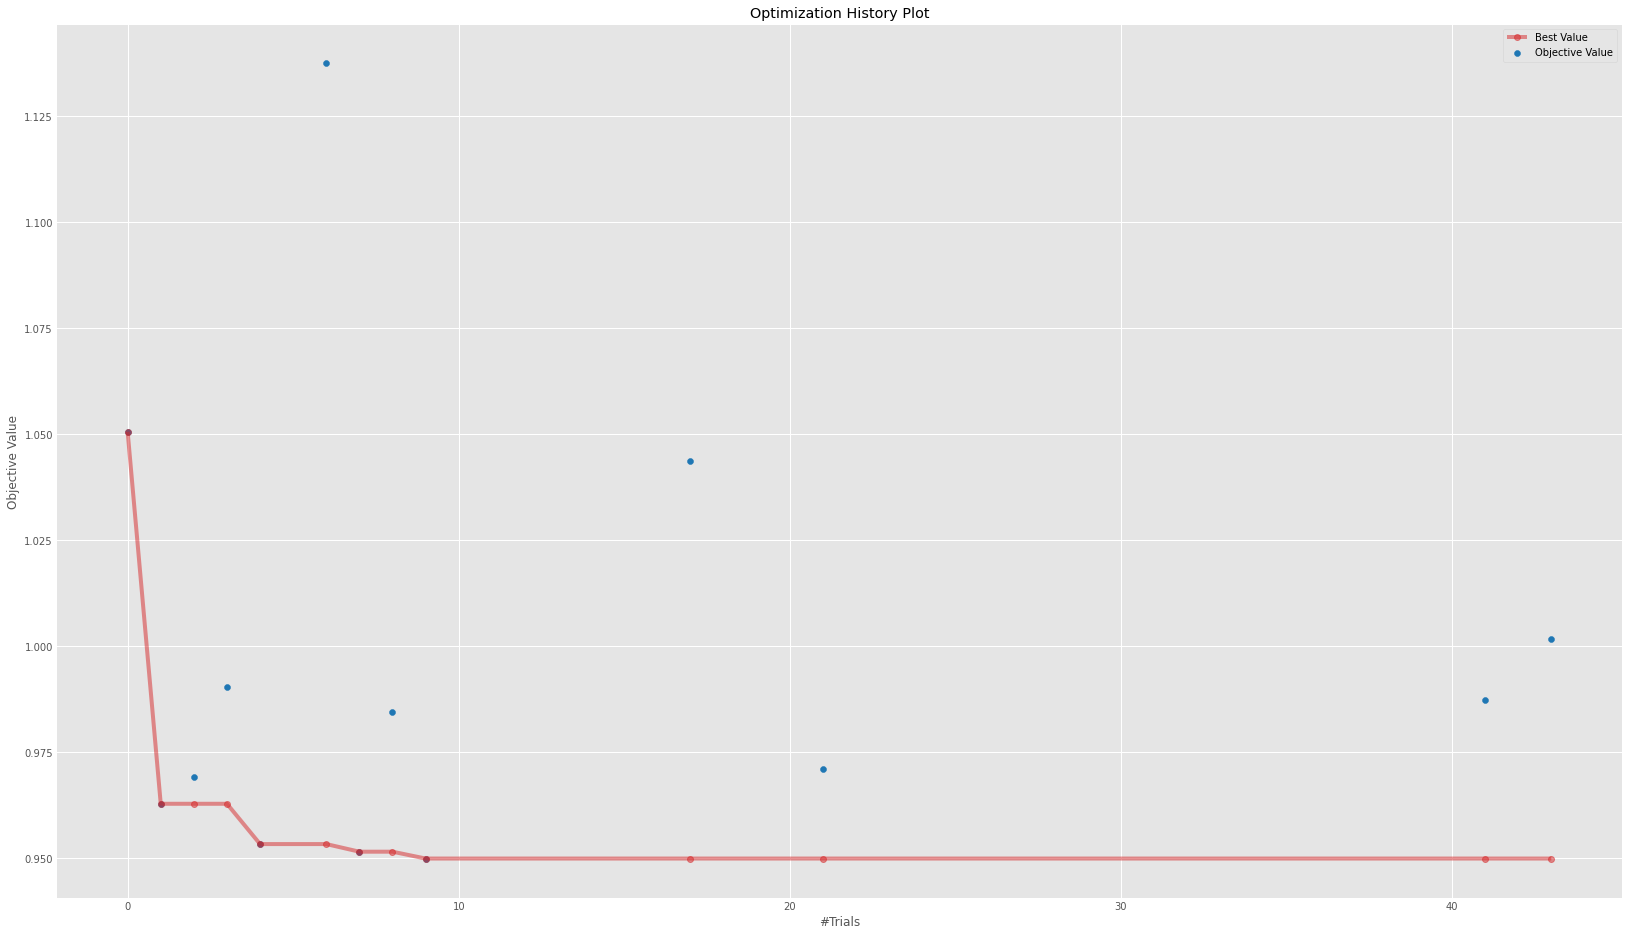

time: 496 ms (started: 2022-02-12 09:52:57 +00:00)


In [67]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir +   '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [68]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir +  '_plot_intermediate_values.jpeg' )

<Figure size 1800x1080 with 0 Axes>

time: 158 ms (started: 2022-02-12 09:52:57 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



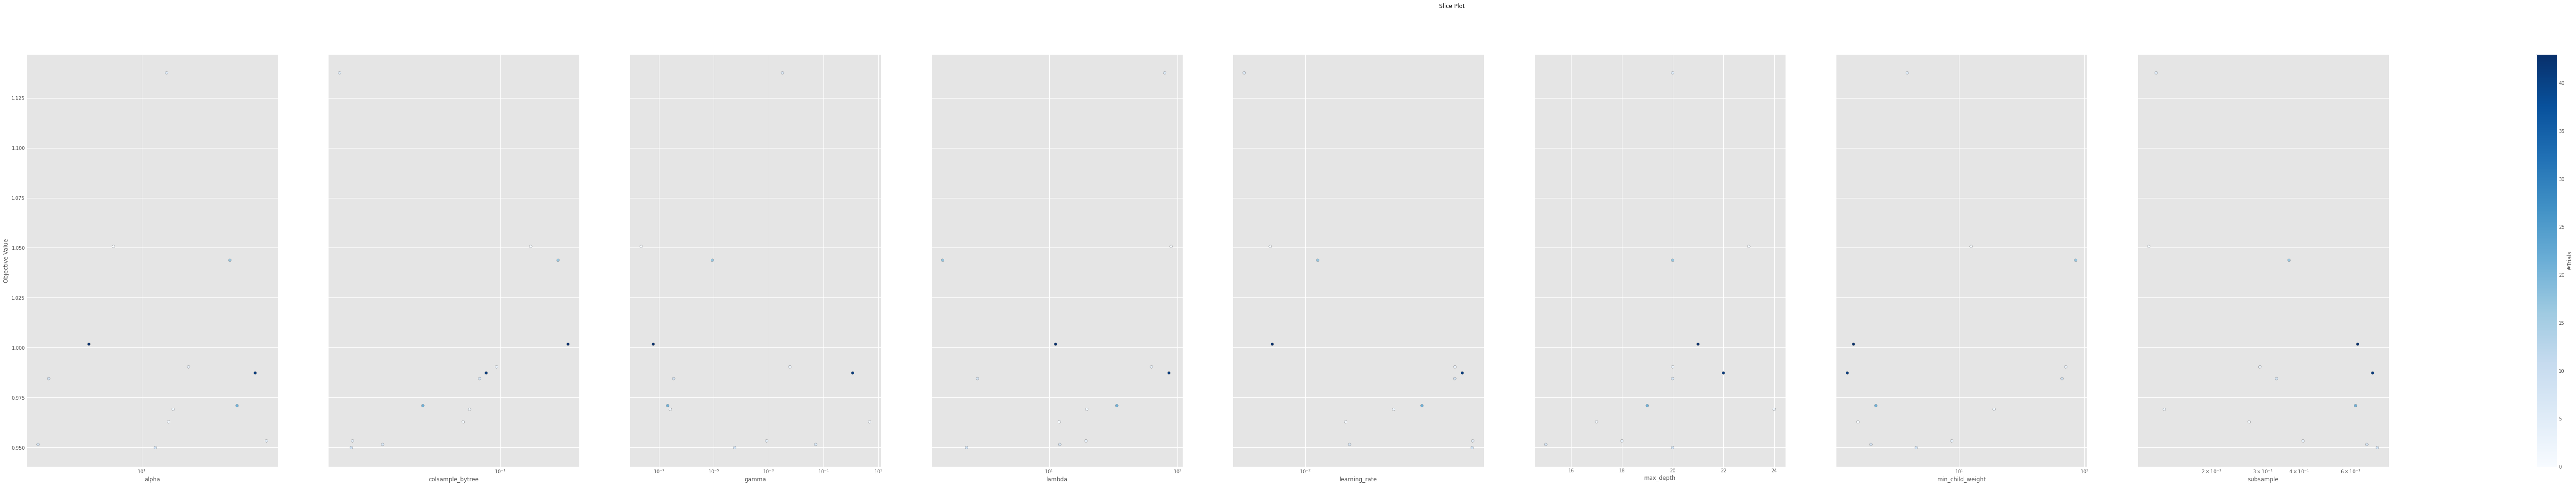

time: 3.55 s (started: 2022-02-12 09:52:57 +00:00)


In [69]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir +   '_plot_slice.jpeg',bbox_inches='tight' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



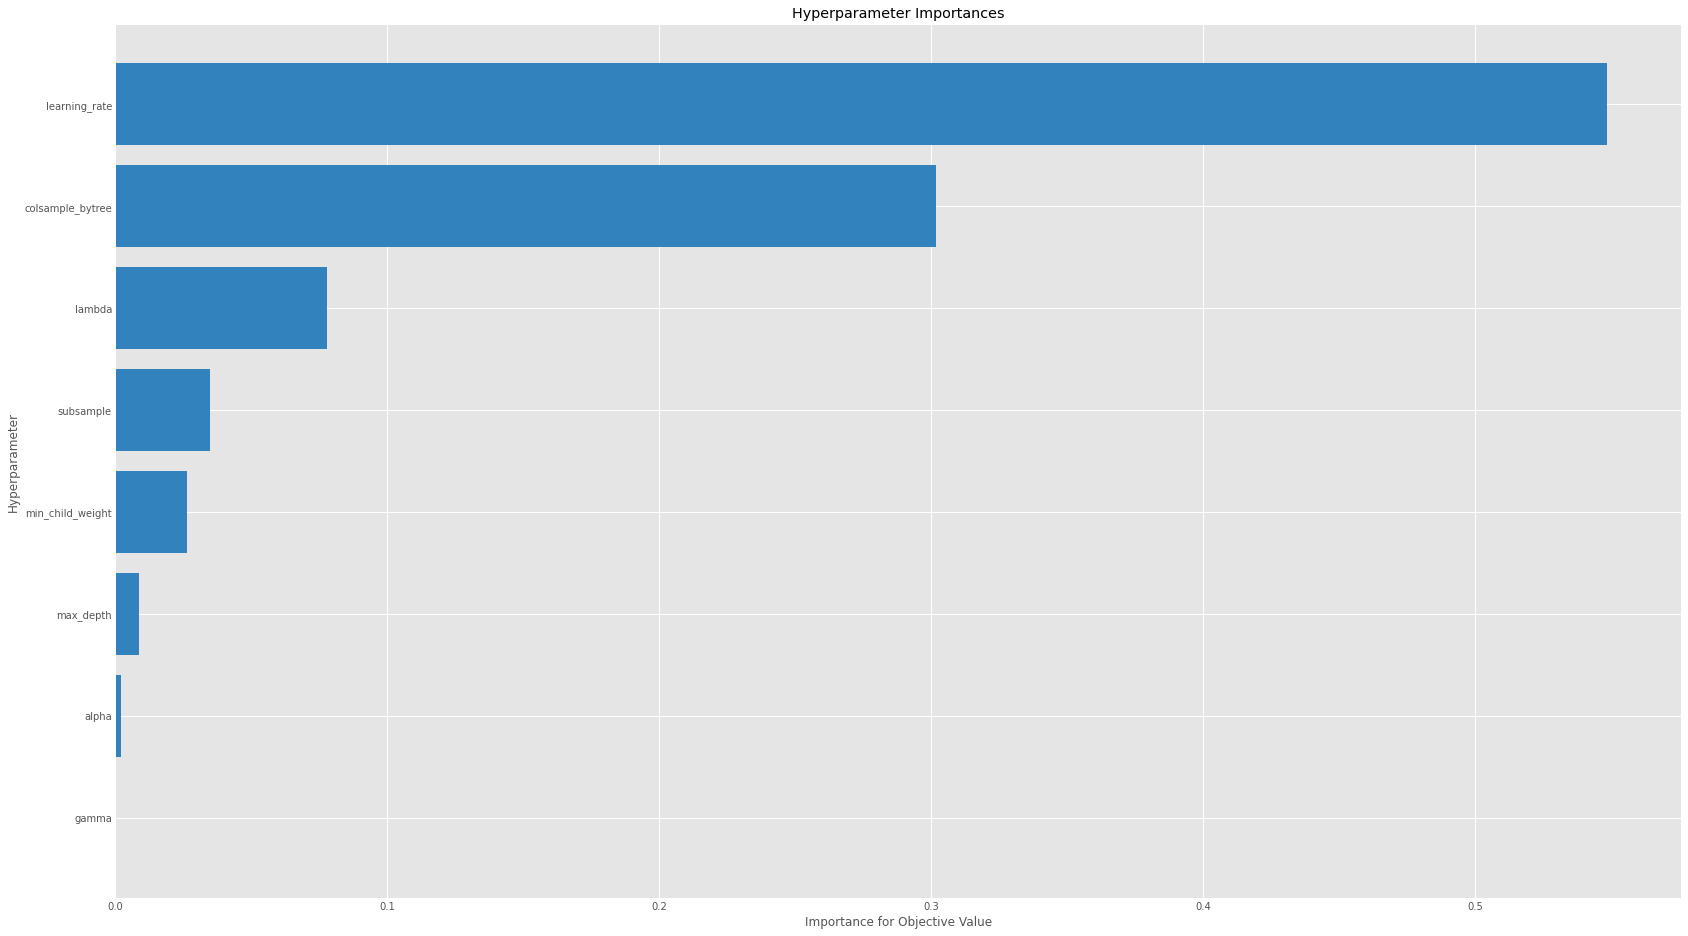

time: 816 ms (started: 2022-02-12 09:53:01 +00:00)


In [70]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir  +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

In [71]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 9: score 0.949861,
params {'max_depth': 20, 'learning_rate': 0.048999493065005714, 'colsample_bytree': 0.023336050059516965, 'subsample': 0.7423942697499718, 'alpha': 12.560821682779899, 'lambda': 2.2757240579385907, 'gamma': 5.836375062984215e-05, 'min_child_weight': 4.549421887517412}
time: 2.85 ms (started: 2022-02-12 09:53:02 +00:00)


In [72]:
study.best_trial.params

{'alpha': 12.560821682779899,
 'colsample_bytree': 0.023336050059516965,
 'gamma': 5.836375062984215e-05,
 'lambda': 2.2757240579385907,
 'learning_rate': 0.048999493065005714,
 'max_depth': 20,
 'min_child_weight': 4.549421887517412,
 'subsample': 0.7423942697499718}

time: 5.84 ms (started: 2022-02-12 09:53:02 +00:00)


# Evaluate best trials on test set 

In [73]:
# define DL model 
# layer_number = int(study.best_trial.params['layer_number'])
layer_number  = 2 
print('DL model layer output = {}'.format(model.layers[layer_number].name))
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)

DL model layer output = dense
time: 6.42 ms (started: 2022-02-12 09:53:02 +00:00)


In [74]:
# predict features with neural net on WHOLE TRAIN and test
train_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_train, #/!\ vs df_train_
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_train_features = intermediate_layer_model.predict(train_generator)
#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_test_features = intermediate_layer_model.predict(test_generator)

Found 4000 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
time: 14.6 s (started: 2022-02-12 09:53:02 +00:00)


In [75]:
# define target on WHOLE TRAIN and test
y_train ,  y_test = df_train['label'] , df_test['label']

time: 1.37 ms (started: 2022-02-12 09:53:16 +00:00)


In [76]:
# #get XGB param 
XGB_best_param = {}
for k,v in study.best_params.items():
  if k != 'layer_number':
    XGB_best_param[k] = v 
# Get number of trees 
bst_study_nb = study.best_trial.number
n_estimators_early_stop = int(study.trials_dataframe().loc[bst_study_nb,'user_attrs_n_estimators'])
n_estimators_early_stop

164

time: 12.9 ms (started: 2022-02-12 09:53:16 +00:00)


In [77]:
best_mod= XGBClassifier(**XGB_best_param,
                         n_estimators = n_estimators_early_stop , # to set number of tree found using early stopping
                        verbosity = 2,
                        tree_method=tree_method,
                        n_jobs=-1) 
best_mod.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=12.560821682779899, colsample_bytree=0.023336050059516965,
              gamma=5.836375062984215e-05, lambda=2.2757240579385907,
              learning_rate=0.048999493065005714, max_depth=20,
              min_child_weight=4.549421887517412, n_estimators=164, n_jobs=-1,
              subsample=0.7423942697499718, tree_method='gpu_hist',
              verbosity=2)>

time: 4.29 ms (started: 2022-02-12 09:53:16 +00:00)


In [78]:
study.best_params

{'alpha': 12.560821682779899,
 'colsample_bytree': 0.023336050059516965,
 'gamma': 5.836375062984215e-05,
 'lambda': 2.2757240579385907,
 'learning_rate': 0.048999493065005714,
 'max_depth': 20,
 'min_child_weight': 4.549421887517412,
 'subsample': 0.7423942697499718}

time: 3.12 ms (started: 2022-02-12 09:53:16 +00:00)


In [79]:
best_mod = SVC(C=0.21182087175130018)

time: 693 µs (started: 2022-02-12 09:53:16 +00:00)


In [80]:
# fit 
# best_mod.fit(X_train_features, y_train,verbose=True)
best_mod.fit(X_train_features, y_train)

SVC(C=0.21182087175130018)

time: 3.34 s (started: 2022-02-12 09:53:16 +00:00)


In [81]:
# predict label with XGBoost 
test_pred_class = best_mod.predict(X_test_features).astype(int)

time: 1.36 s (started: 2022-02-12 09:53:20 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       171
           1       0.76      0.82      0.79       169
           2       0.62      0.67      0.64       126
           3       0.60      0.62      0.61       139
           4       0.80      0.71      0.75       133
           5       0.62      0.66      0.64       147
           6       0.58      0.46      0.51       115

    accuracy                           0.66      1000
   macro avg       0.66      0.65      0.66      1000
weighted avg       0.66      0.66      0.66      1000



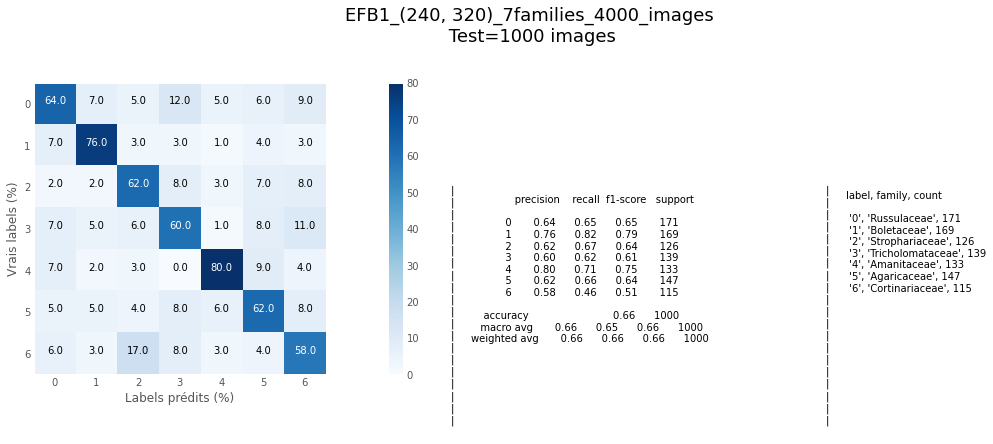

time: 718 ms (started: 2022-02-12 09:53:21 +00:00)


In [82]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'Hybrid_model_conf_matrix.jpeg' ,bbox_inches = 'tight')

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_units_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-12 09:53:22,254] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_contour.py:412: UserWarning:

No contour levels were found within the data range.

